# "Save The Expanse" Twitter Campaign Analysis
Hashtags included (case-insensitive):
- #TheExpanse
- #SaveTheExpanse
- #RenewTheExpanse
- #WatchExpanseLive
- #KeepTheRociFlying
- #ScreamingFirehawks
- #CantStopTheWork
- #RememberTheCant

In [48]:
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from matplotlib import rcParams

# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = 'times new roman'
sns.set(style='whitegrid', context='poster')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Import data and clean

In [4]:
df = pd.read_csv('../data/the-expanse-clean.csv')

# Remove 2 records with 'NaN' timestamps
df = df[df['timestamp'].notnull()]

# Convert timestamps to datetime objects and sort
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by = 'timestamp')

# Timestamps are in UTC. Convert to EST.
df['timestamp'] = df['timestamp'] - pd.Timedelta(hours=6)
df = df.set_index('timestamp')

# Limit date range to may
df = df[df.index.month == 5]

# Sample of tweets

In [44]:
df.sample(20).text

timestamp
2018-05-15 10:53:00    You want hardcore fans? #TheExpanse has hardco...
2018-05-18 02:03:00    #SaveTheExpanse io9: Last Night's #TheExpanse ...
2018-05-19 23:05:00    Baut da keinen Mist! Ich zähle auf euch morgen...
2018-05-23 07:21:00    From my world of marketing, one hashtag is bes...
2018-05-26 04:46:00    WOOP WOOP WOOP!! #TheExpanse https://twitter.c...
2018-05-17 16:19:00    I was so happy for this scene that i missed Na...
2018-05-23 13:21:00         MMMM Mushrooms #TheExpanse #WatchExpanseLive
2018-05-16 05:47:00    Four tvs. Three dvrs. I always rewatch #TheExp...
2018-05-14 05:15:00    This is already 10% of the way funded and it's...
2018-05-18 12:24:00    Great to see #Canadian made #SciFi show #TheEx...
2018-05-27 00:41:00    #TheExpanse : Cette série arrive encore à me s...
2018-05-30 13:05:00                        Watching #theexpanse on @SYFY
2018-05-24 00:21:00    Thursdays are better than Fridays: a tradition...
2018-05-17 10:02:00    Fred is watching :

# Basic Info

In [6]:
print('Hashtag: #TheExpanse')

start_date = str(min(df.index).date())
end_date = str(max(df.index).date())
print(f'Date range: {start_date} to {end_date}')

num_uniq_tweets = df['text'].nunique()
print(f'Number of unique tweets: {num_uniq_tweets}')

num_tot_tweets = df['retweets'].sum() + num_uniq_tweets
print(f'Number of tweets and retweets: {int(num_tot_tweets)}')

num_uniq_users = df['user'].nunique()
print(f'Number of unique users who wrote original tweets: {num_uniq_users}')

Hashtag: #TheExpanse
Date range: 2018-05-08 to 2018-05-31
Number of unique tweets: 45356
Number of tweets and retweets: 179765
Number of unique users who wrote original tweets: 10775


# Most prolific tweeters

Text(0.5,1,'Most prolific tweeters')

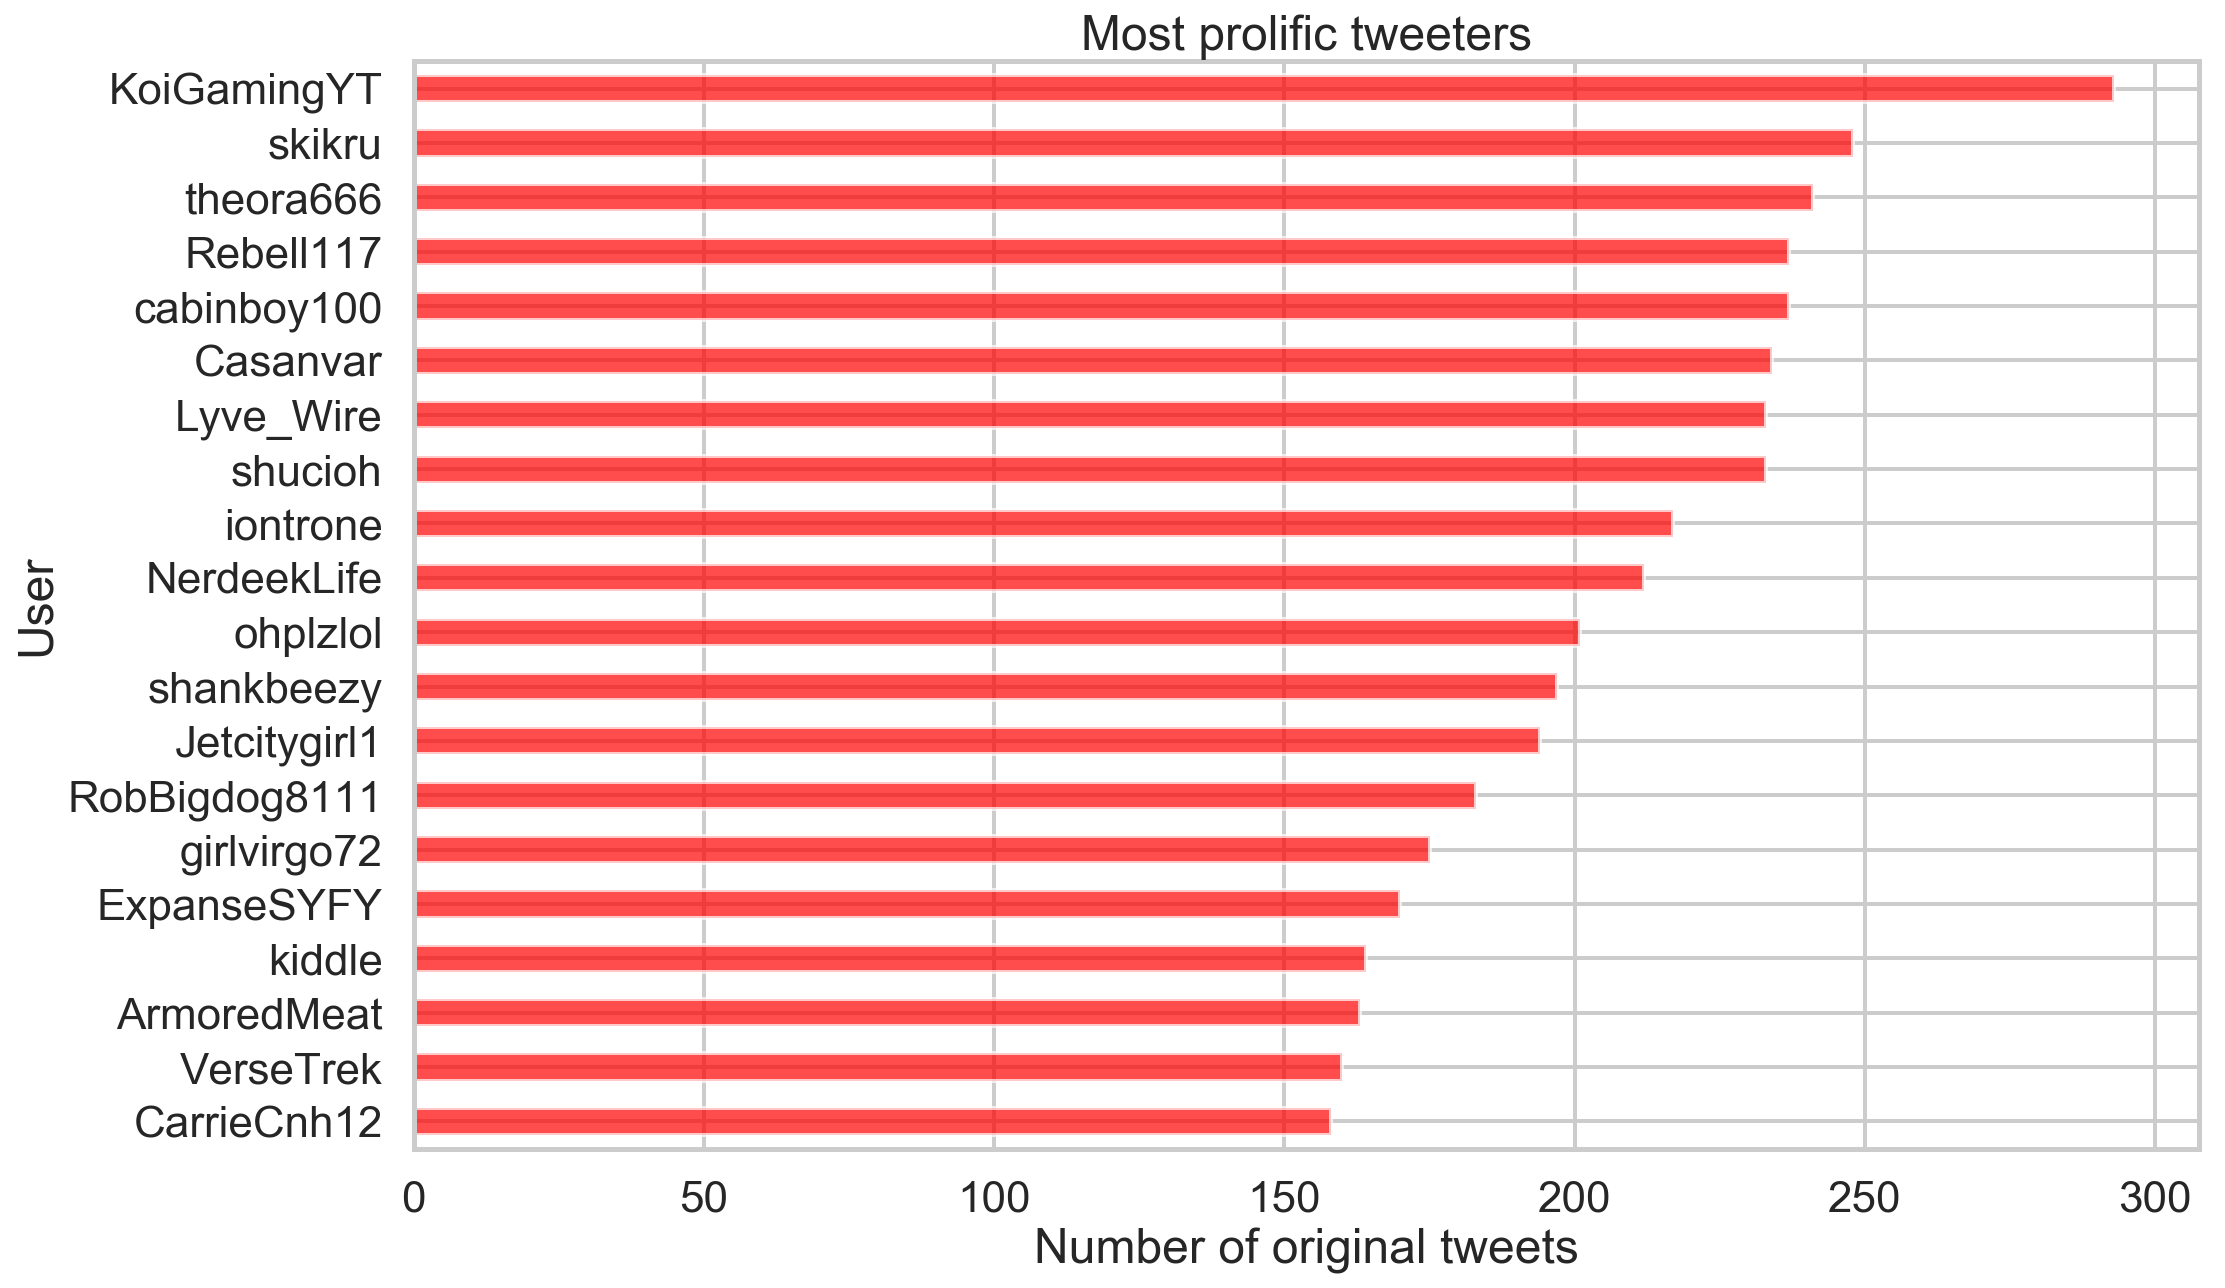

In [7]:
most_prolific = df['user'].value_counts().head(20)
most_prolific = most_prolific.sort_values(ascending=True)
ax = most_prolific.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16,10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of original tweets')
ax.set_title('Most prolific tweeters')

# Most influential tweeters (by retweets)

Text(0.5,1,'Most influential tweeters')

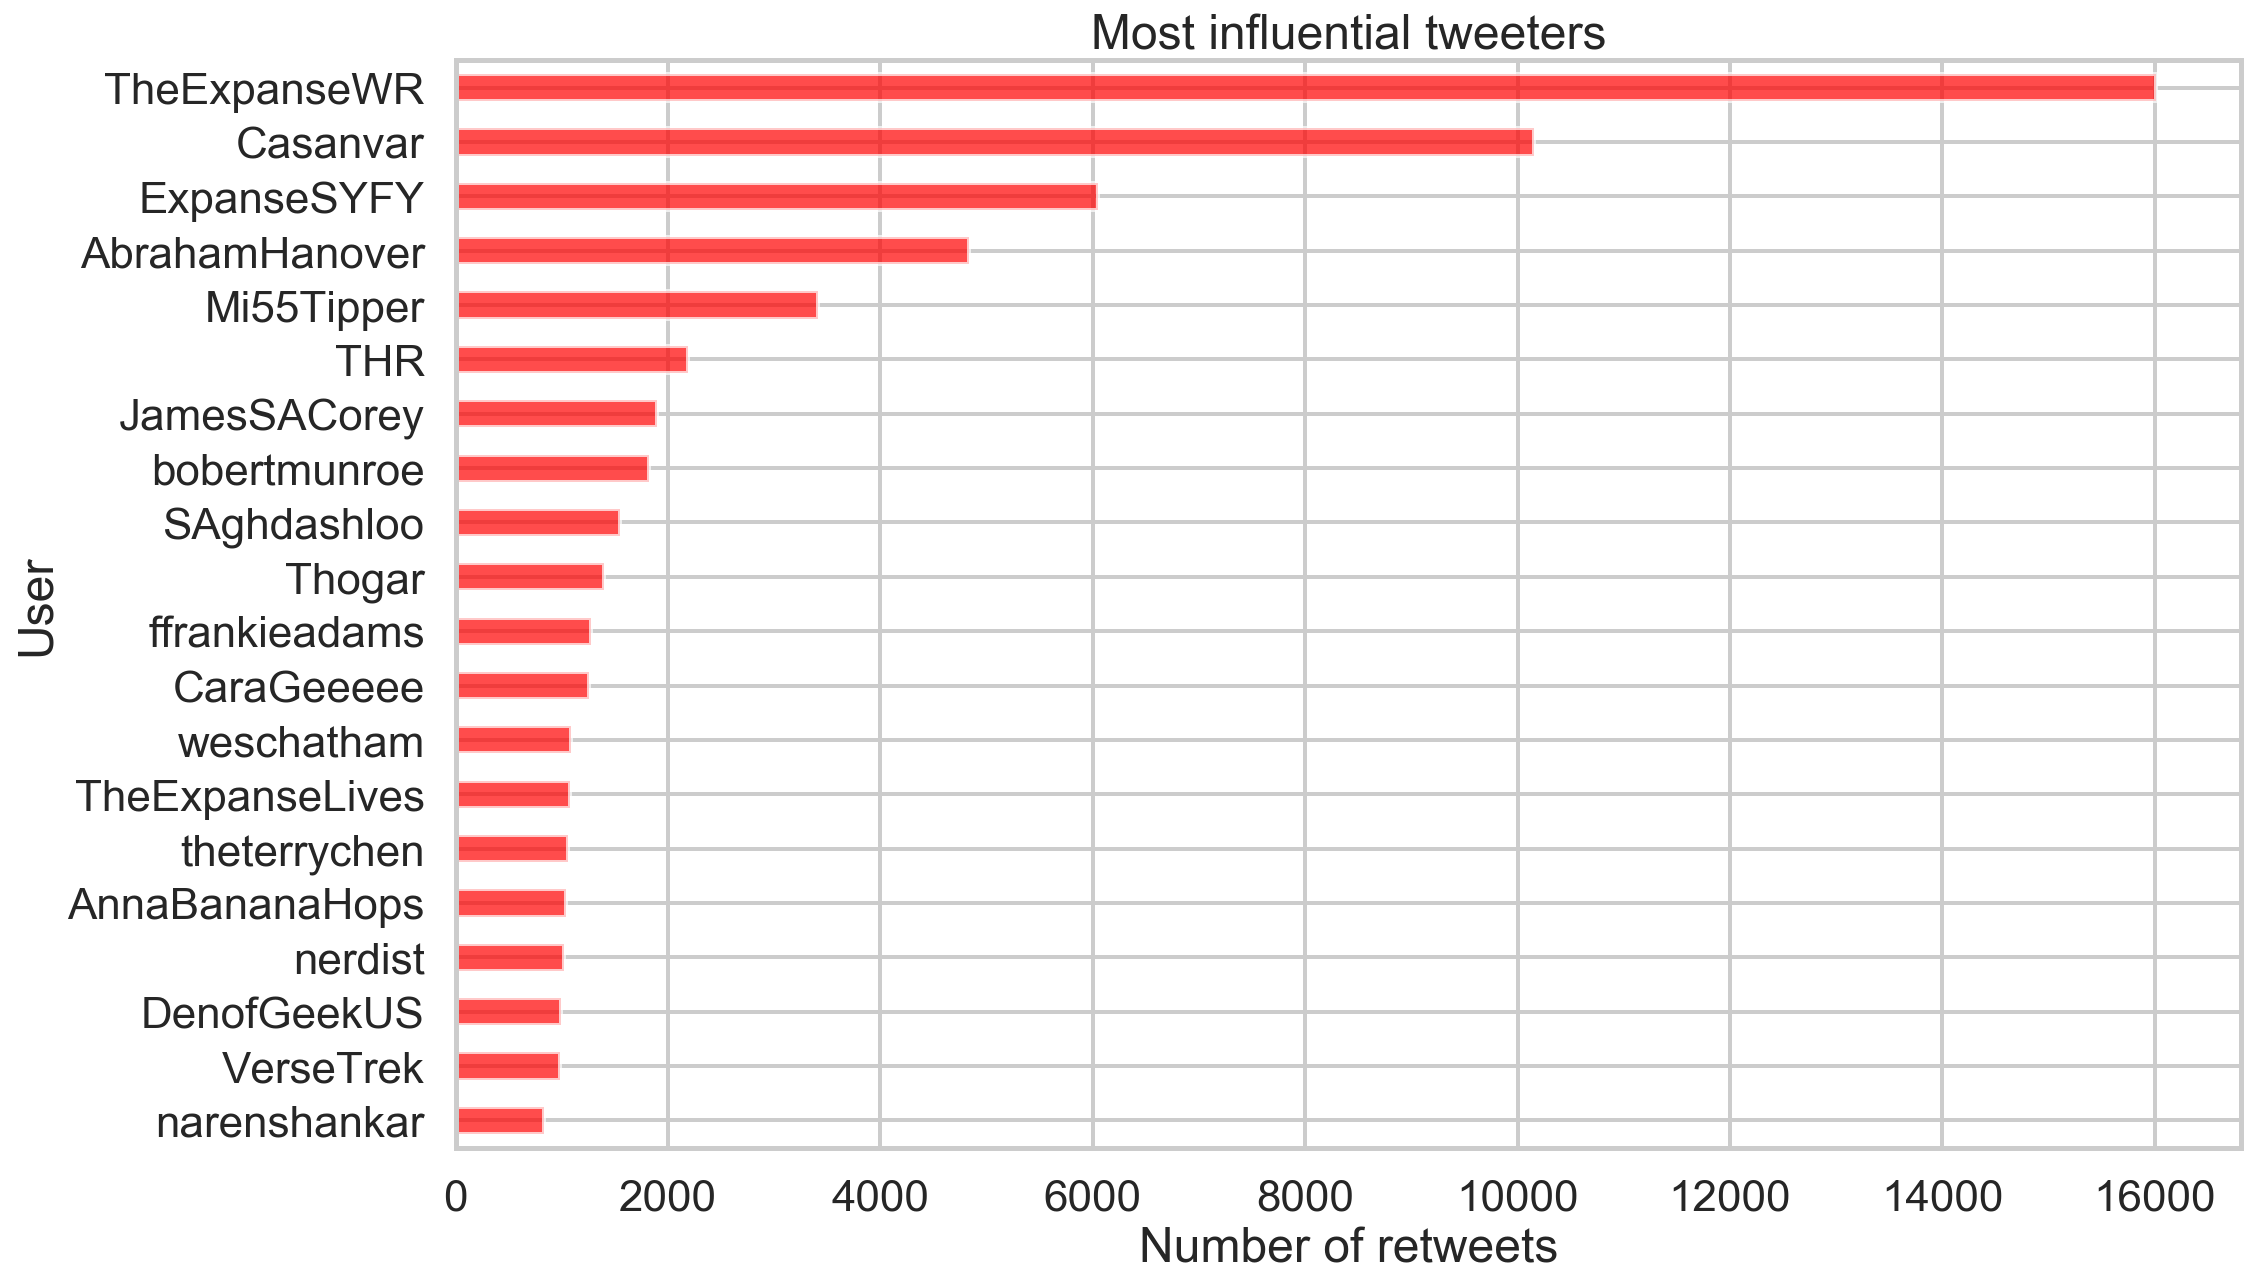

In [10]:
most_influential = df.groupby('user')['retweets'].sum().sort_values().tail(20)
ax = most_influential.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16, 10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of retweets')
ax.set_title('Most influential tweeters')

# Most influential tweeters (by likes)

Text(0.5,1,'Most liked tweeters')

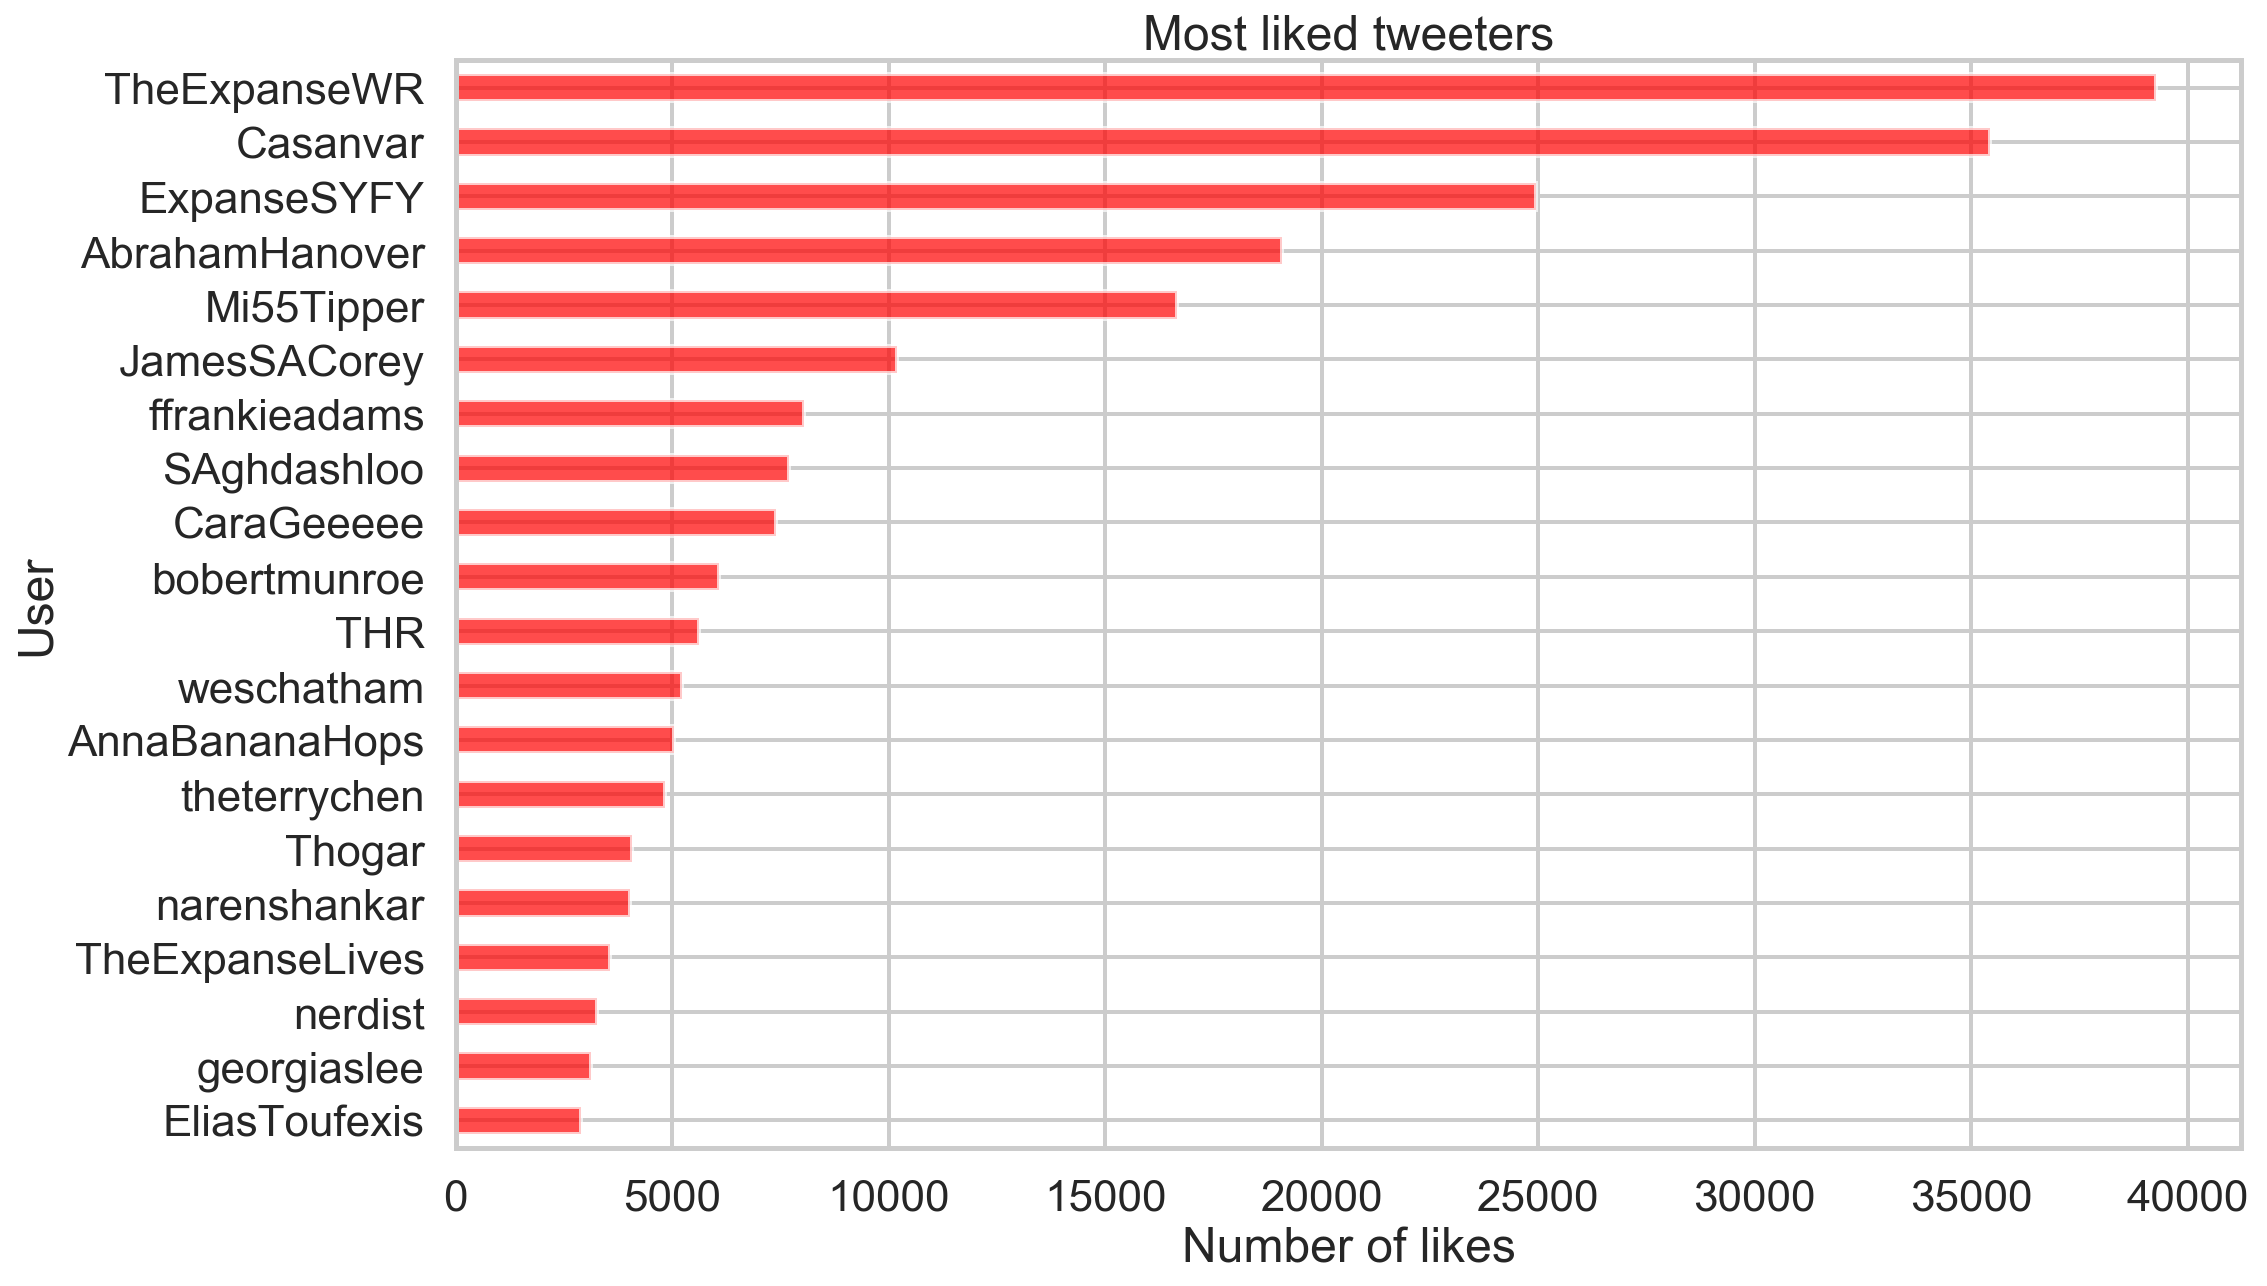

In [11]:
most_influential = df.groupby('user')['likes'].sum().sort_values().tail(20)
ax = most_influential.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16, 10),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of likes')
ax.set_title('Most liked tweeters')

# Most influential (normalized by number of tweets)

Text(0.5,1,'Most influential tweeters (normalized)')

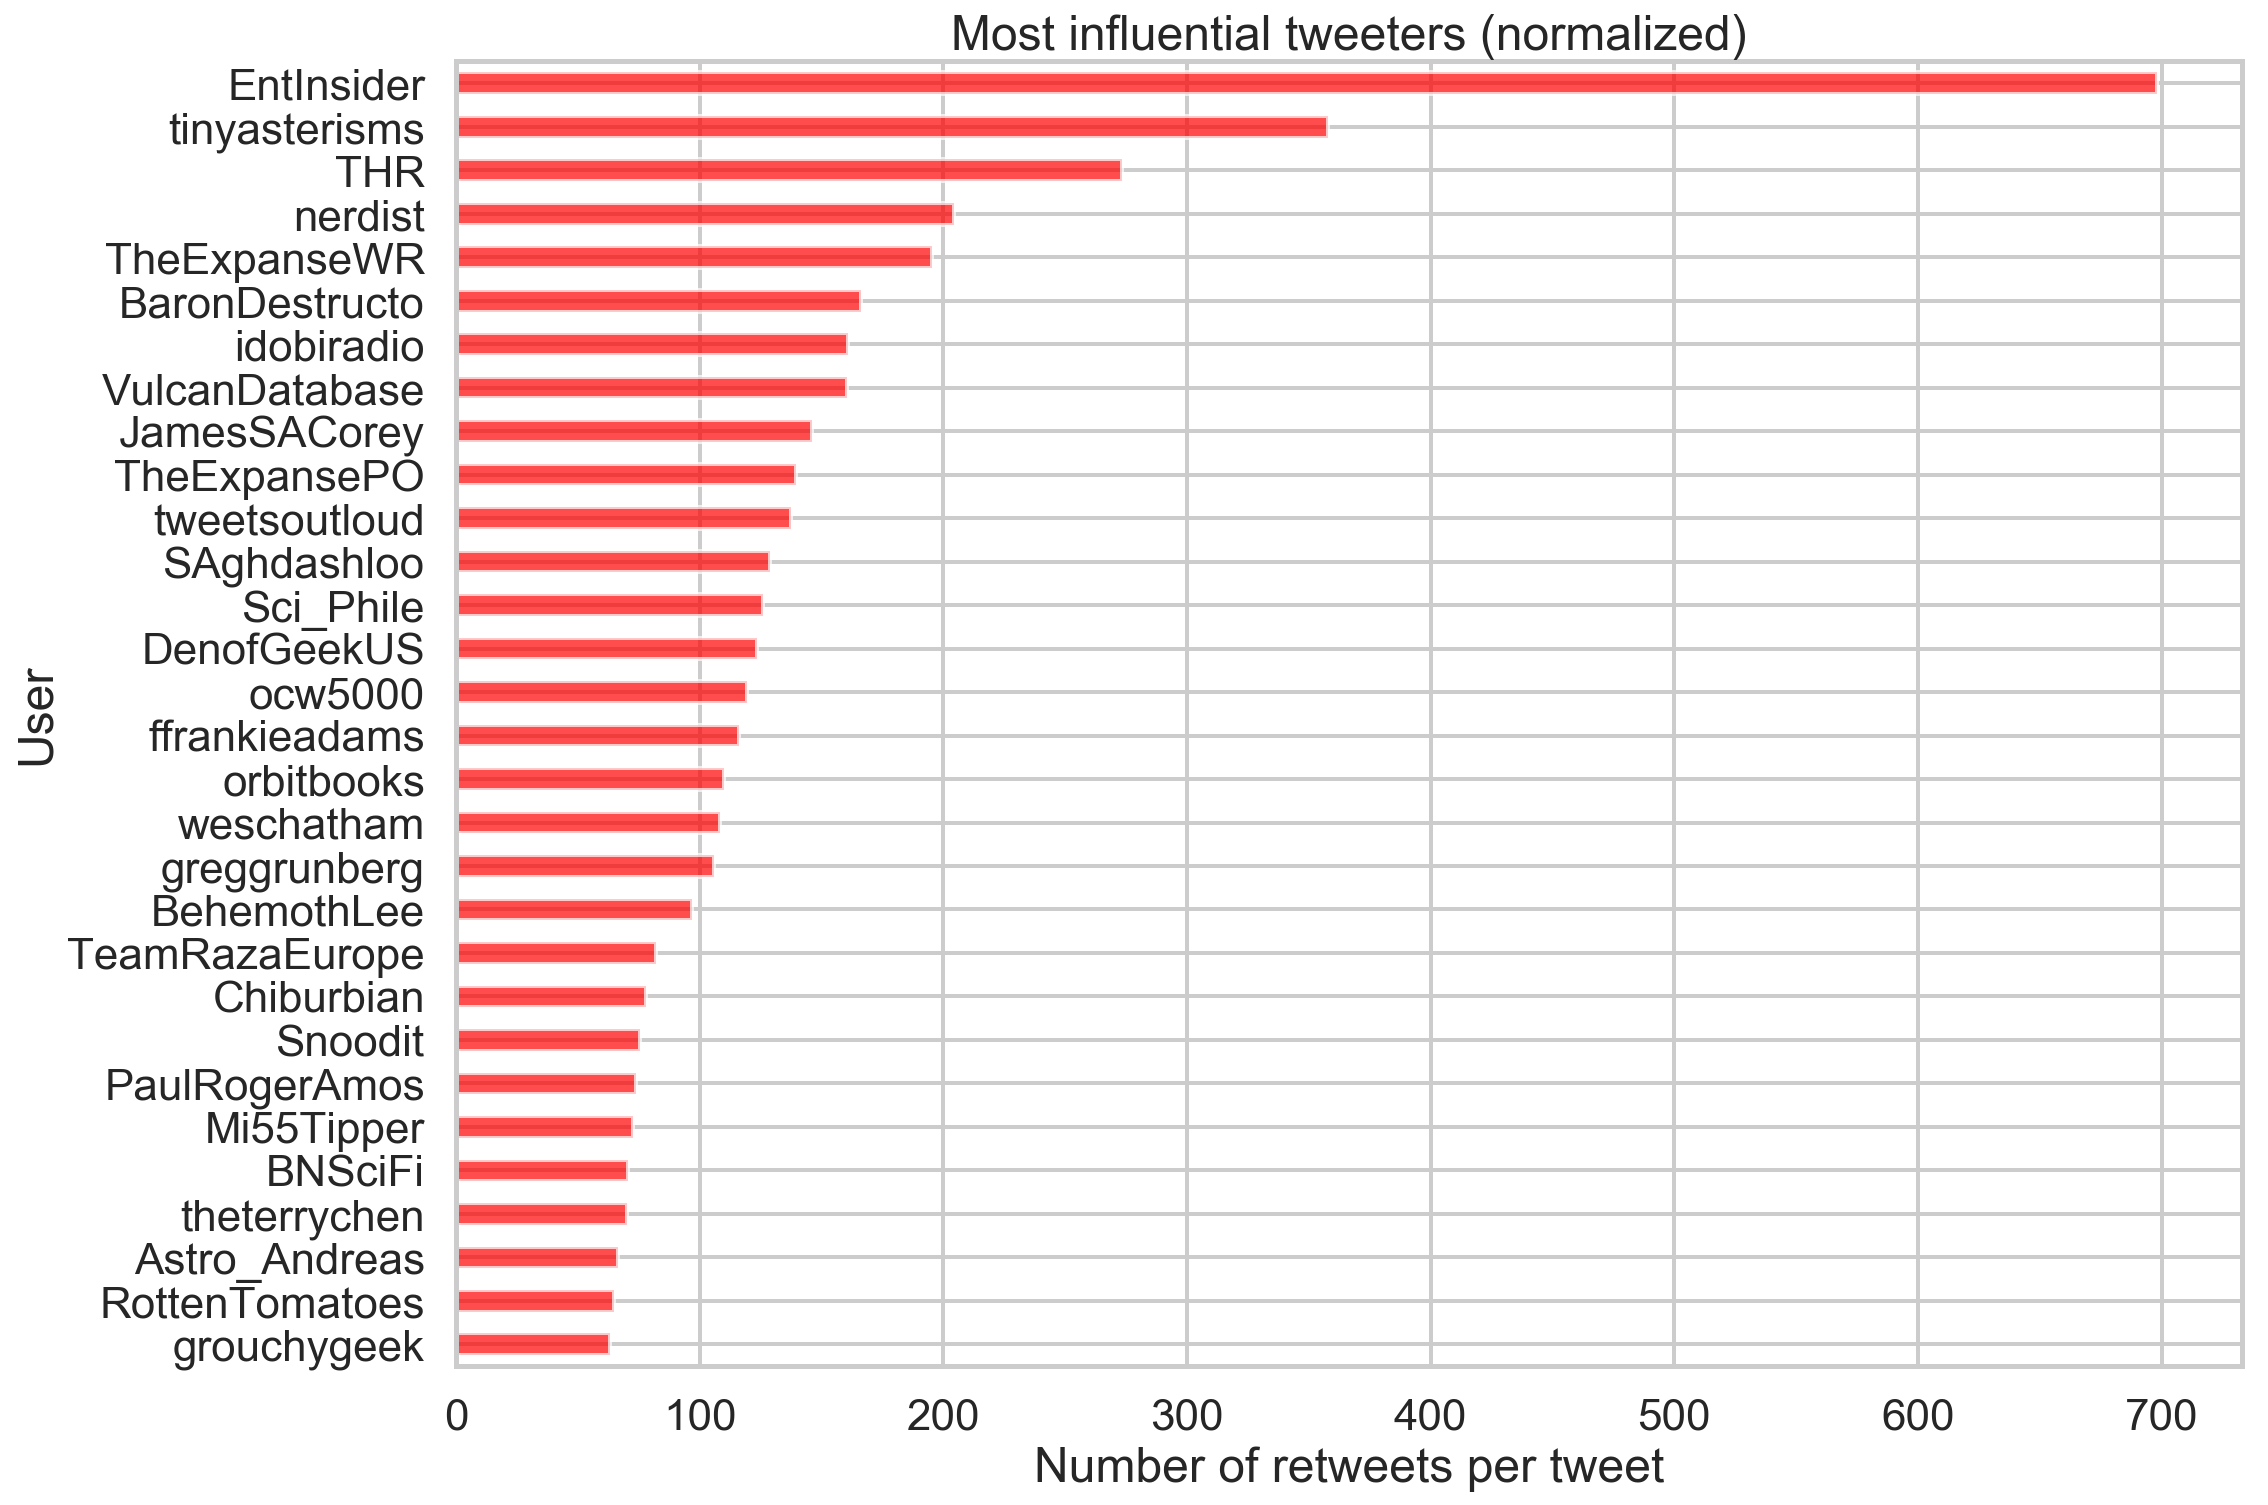

In [12]:
most_influential = df.groupby('user')['retweets'].sum().sort_values()
num_tweets_per_user = df['user'].value_counts()
num_tweets_per_user.name = 'num_tweets'
merged = pd.concat([most_influential, num_tweets_per_user], axis='columns')
most_influential_norm = merged['retweets'] / merged['num_tweets']
most_influential_norm = most_influential_norm.sort_values().tail(30)

ax = most_influential_norm.plot.barh(
    color='red',
    grid=True,
    alpha=0.7,
    figsize=(16,12),
)
ax.set_ylabel('User')
ax.set_xlabel('Number of retweets per tweet')
ax.set_title('Most influential tweeters (normalized)')

# Engagement time series

Text(0.5,1,'#TheExpanse Engagement Over Time')

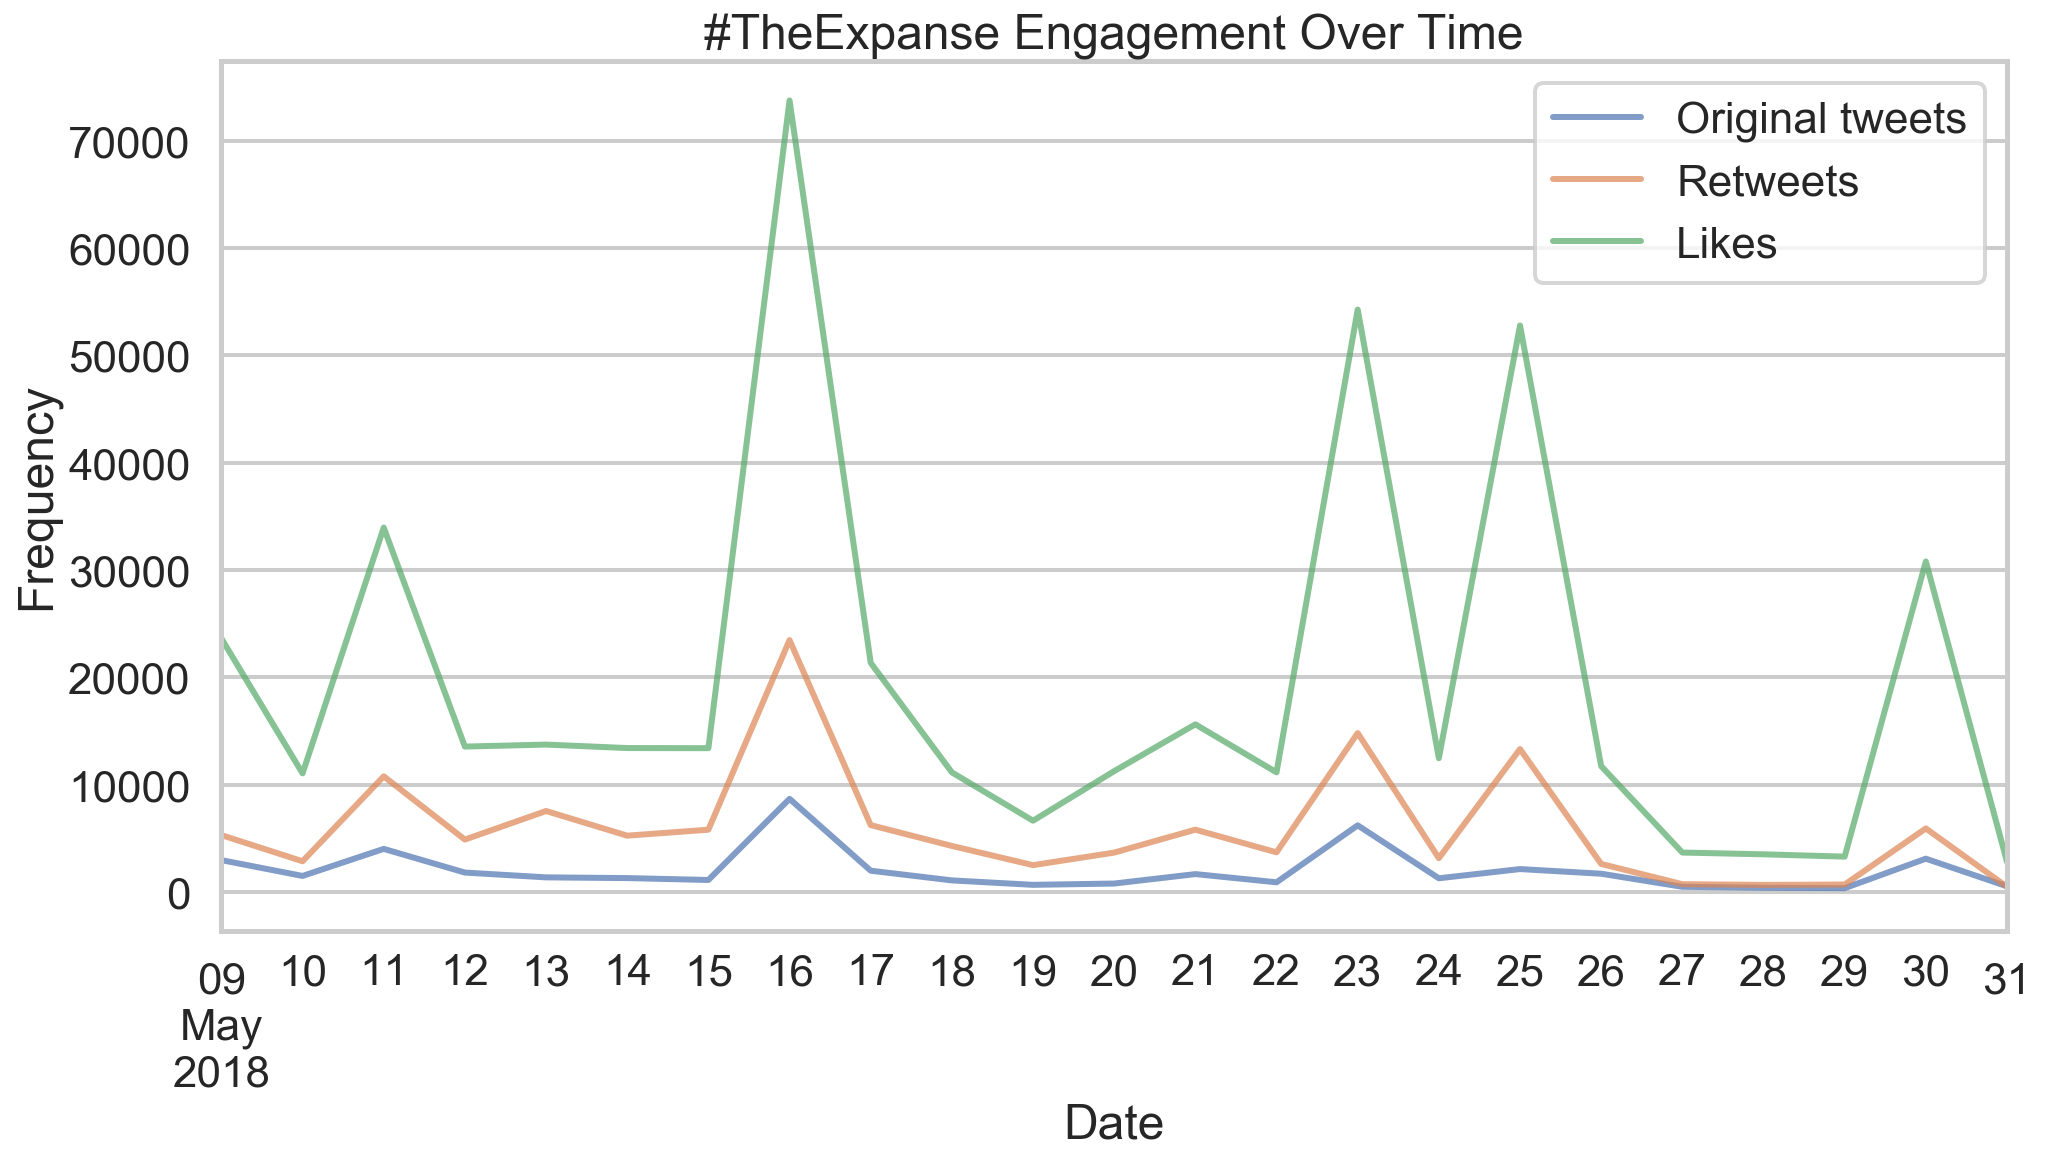

In [54]:
may_num_tweets = df.resample('d').size()
ax = may_num_tweets.plot.line(
    alpha=0.7,
    figsize=(16,8),
    label='Original tweets'
)

for feature in ['retweets', 'likes']:
    may_feature = df.resample('d')[feature].sum()
    may_feature.plot.line(
        ax=ax,
        alpha=0.7,
        label=feature.capitalize()
    )

ax.legend()
ax.set_xlim(17660, 17682)
ax.set_ylabel('Frequency')
ax.set_xlabel('Date')
ax.set_title('#TheExpanse Engagement Over Time')

# Secondary hashtags

In [41]:
hashtags = list()
for tweet in df['text'].str.lower():
    hashtags.extend(re.findall(r'#[a-z|\d]*', tweet))
hashtags = pd.Series(hashtags)

[Text(0,0.5,'Hashtag'),
 Text(0.5,0,'Frequency of use in original tweets'),
 Text(0.5,1,'Most popular secondary hashtags')]

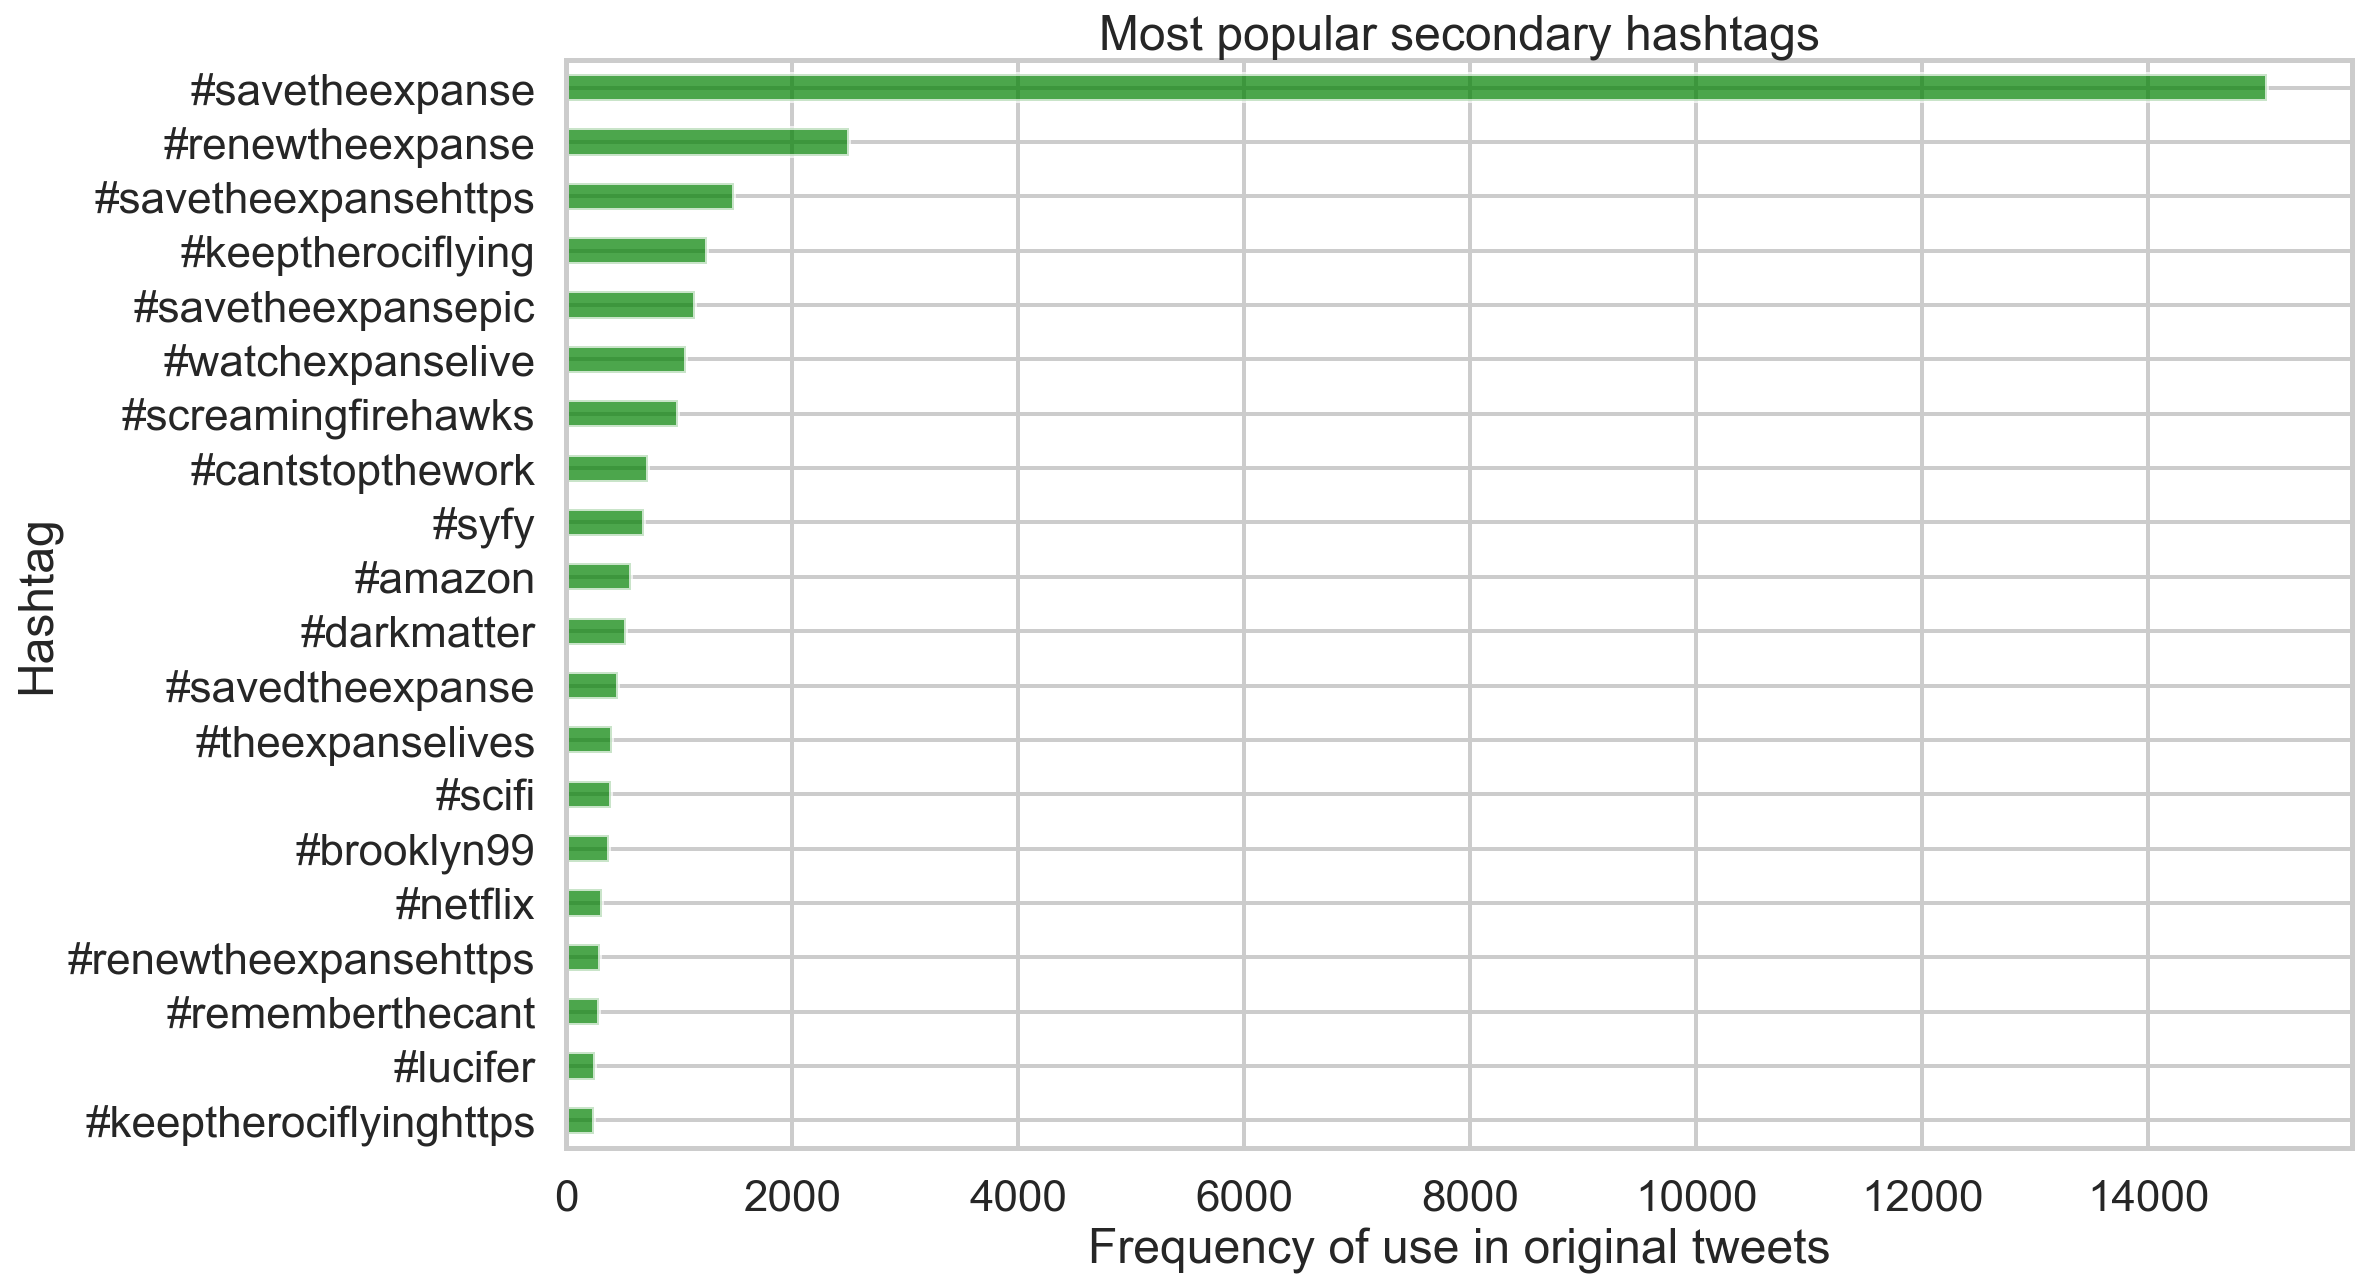

In [42]:
secondary_hashtags = hashtags.value_counts()[1:21]
secondary_hashtags = secondary_hashtags.sort_values(ascending=True)
ax = secondary_hashtags.plot.barh(
    figsize=(16,10),
    color='green',
    alpha=0.7,
)

ax.set(
    title='Most popular secondary hashtags',
    xlabel='Frequency of use in original tweets',
    ylabel='Hashtag'
)

# @'s

[Text(0,0.5,'At'),
 Text(0.5,0,'Frequency of use in original tweets'),
 Text(0.5,1,"Most popular @'s")]

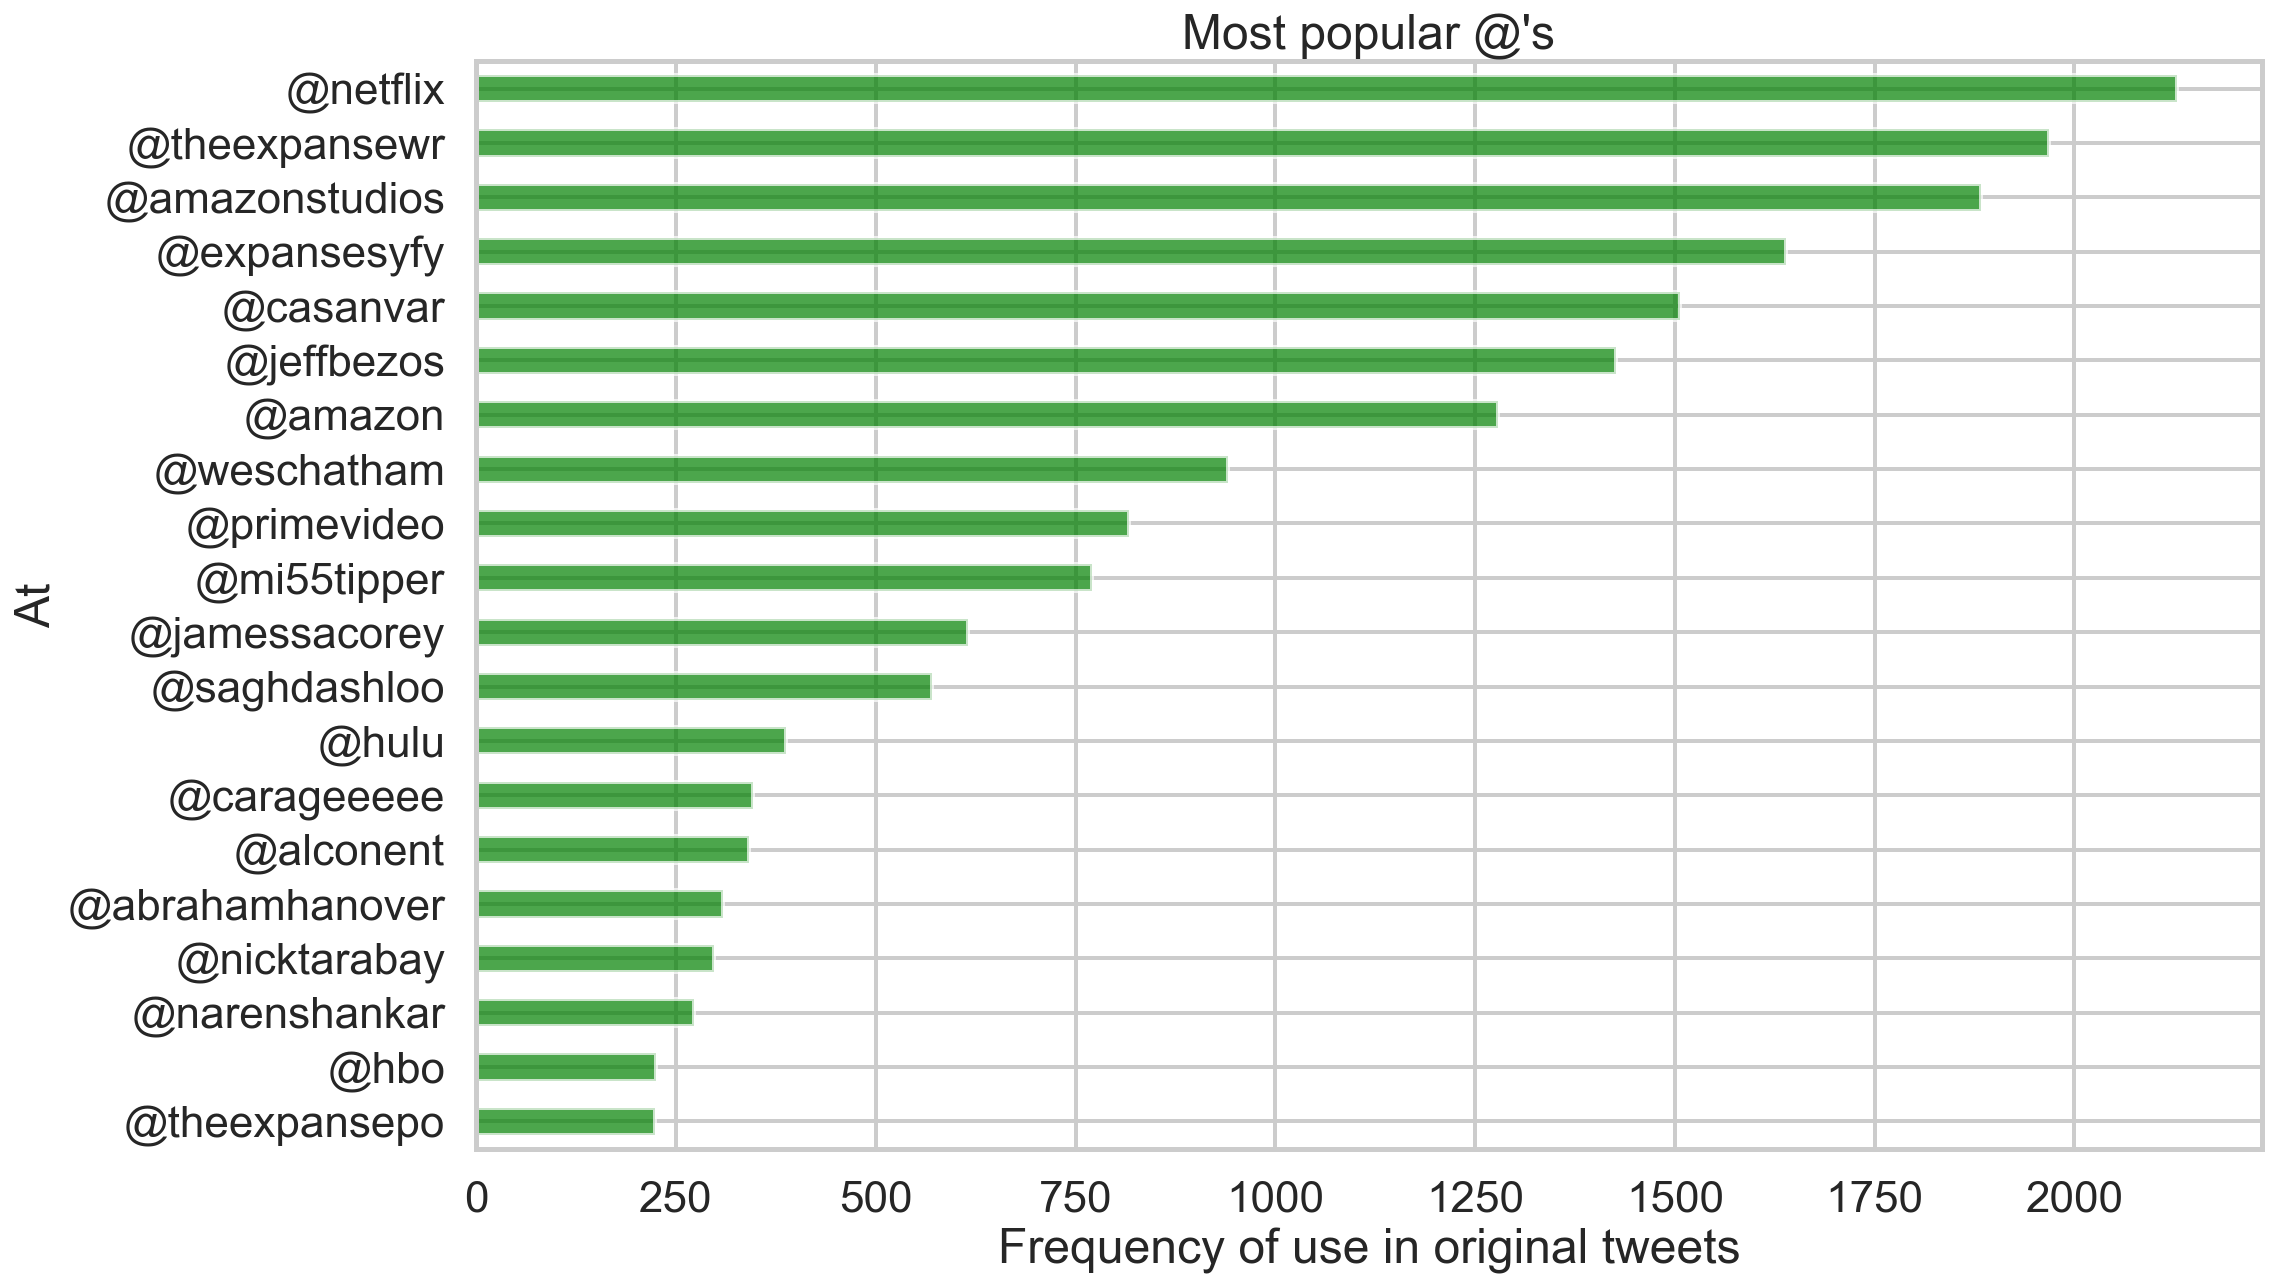

In [17]:
ats = list()
for tweet in df['text'].str.lower():
    ats.extend(re.findall(r'@[a-z|\d]*', tweet))
ats = pd.Series(ats)

ats = ats.value_counts()[1:21]
ats = ats.sort_values(ascending=True)
ax = ats.plot.barh(
    figsize=(16,10),
    color='green',
    alpha=0.7,
)

ax.set(
    title='Most popular @\'s',
    xlabel='Frequency of use in original tweets',
    ylabel='At'
)

# Word cloud

In [18]:
# when creating word clouds, maps word fontsize to a color
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [51]:
tokens = list()

from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))
stopwords.append('…')

for tweet in df['text'].str.lower():
    tweet_tokens = tweet.split()
    for token in tweet_tokens:
        if token.startswith(('#', '@')):
            continue
        if '.com' in token or 'http' in token or ('.' in token and '/' in token):
            continue
        token = re.sub(r'#|@|!|\.|"|\?|&|\*|\(|\)|,', ' ', token)
        token = token.strip()
        if token in stopwords:
            continue
        if token:
            tokens.append(token)
            
tokens = pd.Series(tokens)
tokens = tokens.value_counts()

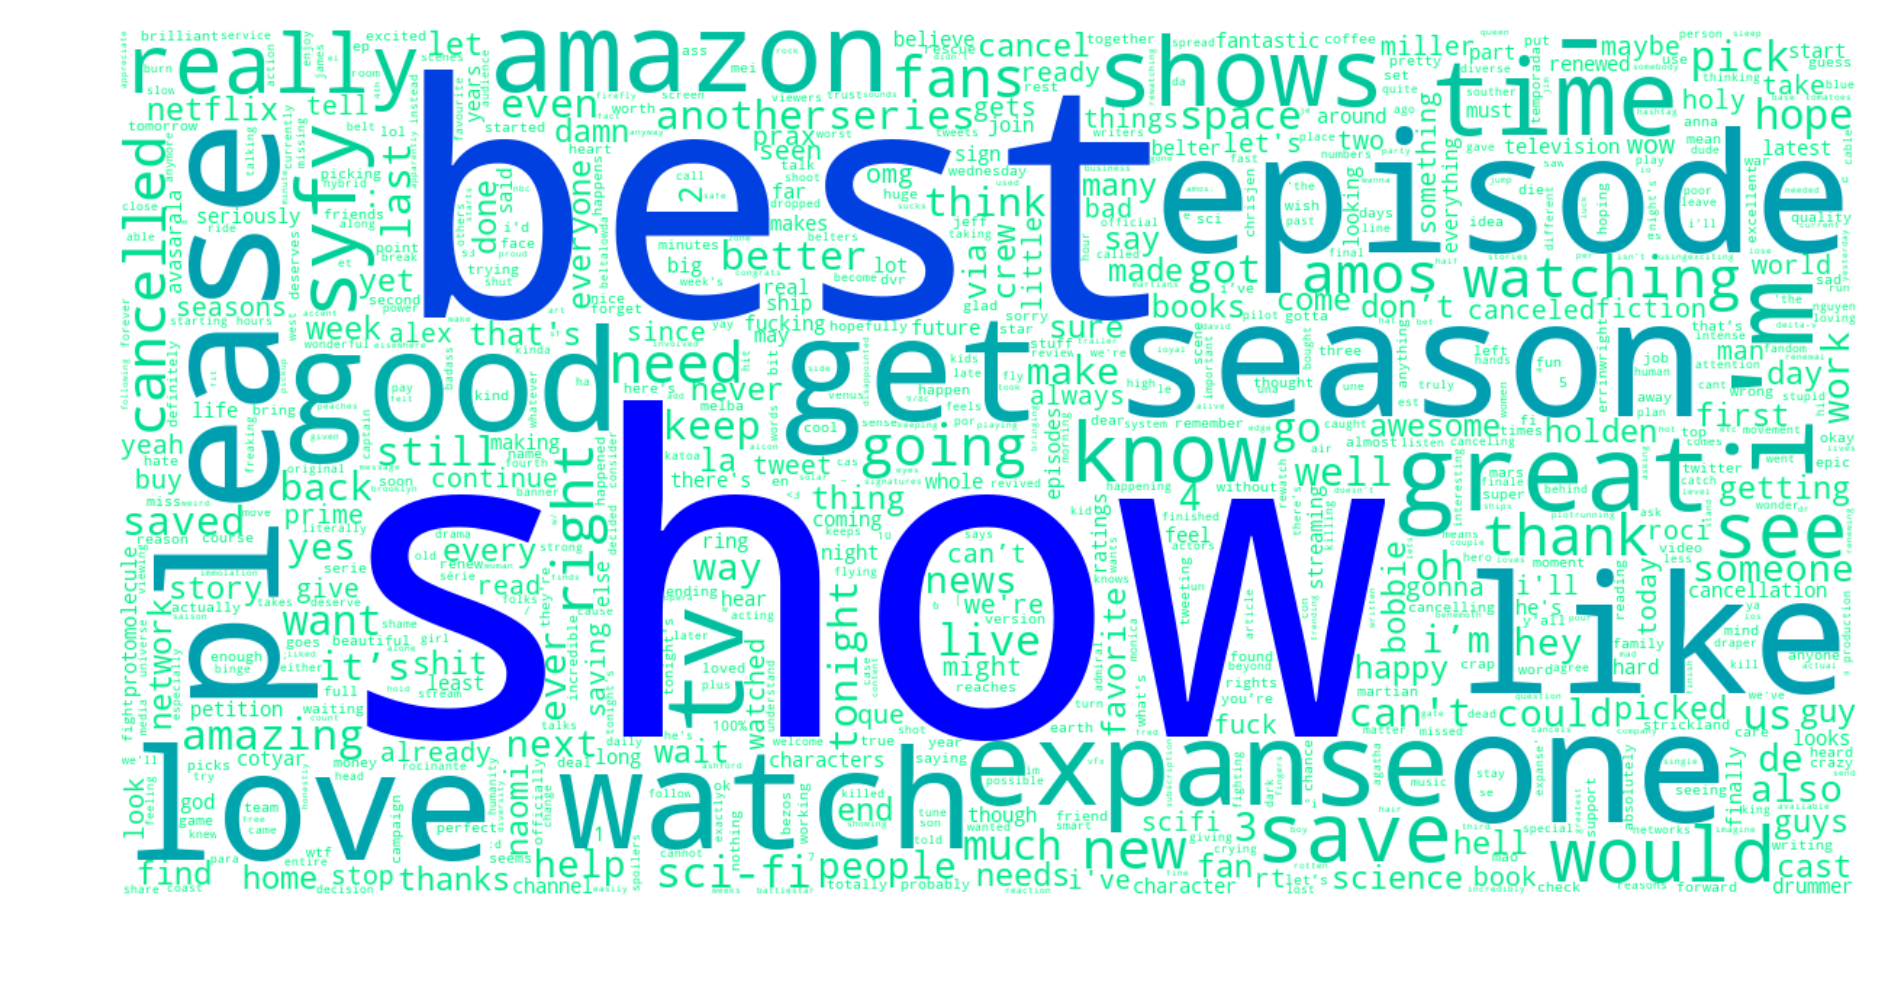

In [53]:
# make word cloud
word_freq_dict = dict(tokens)
wordcloud = WordCloud(background_color='white', height=600, min_font_size=2,
                      width=1200, color_func=colormap_size_func('winter_r', 300),
                      max_words=800)
wordcloud = wordcloud.generate_from_frequencies(word_freq_dict)

# display word cloud
plt.figure(figsize=(16,8))
ax = plt.gca()
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off');